# Apartment Impartment Ltd™
*CS524 Intro to Optimization, 18 December 2021*

Puqian Wang & Sonia Cromp

# Introduction

We are beginning a real-estate technology startup, Apartment Impartment Ltd (AIL)™, which will serve as a middleman between renters and real estate agencies. We decided to start this company in order to help face the issues encountered by student renters. Because many students live in the same small area around campus, move at the same time in August and have similar budgets and preferences (such as wanting a studio or 1-bedroom within walking distance to campus), many students become interested in the same few apartments and need to race to sign a lease before anybody else does. 

Our company will gather available apartments over the course of a week, then recommend an apartment to a prospective renter based on the renter’s preferences. No two renters will be offered the same apartment in the same week. Each renter is given a week to decide on signing a lease, eliminating the time pressure to decide and the disappointment of missing out on a nice apartment by just a few hours. Due to the competitive nature of the Madison rental market, each resident is only offered one apartment per week to guarantee that they alone have the choice to rent this apartment; this guarantee would be too restrictive for providing a renter with more than one apartment because real estate agencies are not interested in tying up several of their apartments at once with one prospective renter. However, the real estate companies (according to our focus group last month) are willing to tie up one apartment per resident in this process, because the prospective residents our company attracts are likely to be high-quality tenants who take the rental process seriously and want to treat their nice apartments with care.


# Data

On our website, a prospective resident will submit a Residence Request informing us of their apartment preferences. The prospective resident $x_j$ specifies their desired number of bedrooms $xbe_j$ and bathrooms $xba_j$, monthly rent amount $xp_j$, desired length of commute to the university $xct_j$ and commute transportation method $xcm_j$ (walking, bicycling or driving). The request also involves specifying the relative importance of each of these attributes for this prospective resident in the form of real-valued numbers between 0 and 1. Specifically, $pbe_j$, $pba_j$, $pp_j$ and $pc_j$ represent the importance of the number of bedrooms and bathrooms, the price and the commute time (using the specified commute method $xcm_j$), respectively, for the $j$-th prospective resident. For each apartment, the available data consist of the number of bedrooms and bathrooms, the rent amount, and the location (which is used to determine commute time to the university for each of the three available methods using the Google Distance Matrix API). 

Because our startup is still in its early stages, the apartment data rely on the Zillow.com API which gathered 63 condos from Madison, Verona, Fitchburg, Sun Prairie and Middleton. Condos easily simulate apartments by dividing the price by 1000 to simulate a monthly rent amount. The resident data is randomly generated to resemble preferences shared by students in our August 2021 focus group, and those reviewing our model are able to toggle the distributions of the resident data to envision model behavior in specific scenarios. These data are used with the proof-of-concept models in an effort to encourage local rental agencies to partner with Apartment Impartment Ltd™.


In [1]:
import pandas as pd
%load_ext gams_magic 

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Resident data
This code block specifies the default settings for the distributions of the resident data. Editing these values also enables exploration of the model under other scenarios. Simply follow the instructions in the comments and unless noted otherwise, keep all numbers as nonnegative integers.

In [2]:
%%gams

# number of residents
# please enter a scalar between 1-100:
scalar num_res /30/;

# beds distribution
# nbed = 0 if studio
scalar nbeds_mean /2/;
scalar nbeds_var/1/;

# budget distrbution
# note: budget is set to 500 if budget is less than 500
scalar budget_mean /1200/;
scalar budget_var /200/;

# commute time distribution
# com_t: normal(time_mean,time_var)
# partitioned by a vector time_slot(t): _t1_t2_t3_t4_t5_
# com_t is set to 1 if com_t<t1; set to 2 if between t1 and t2; etc.
scalar time_mean /15/;
scalar time_var /5/;

set slot /t1*t5/;
parameter time_slot(slot)
/t1 5,
 t2 10,
 t3 15,
 t4 20,
 t5 25/;

# ranking distribution: how important a resident might consider some arbitrary attribute
# for each resident, the sum of these rankings is normalized to add to 1
scalar rank_mean /0/;
scalar rank_var /1/;


The following code uses the above distribution to generate resident data:

In [3]:
%%gams
set r /1*100/;
set cr(r);
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
set labels /'nbed', 'nbath', 'budget', 'com_m', 'com_t'/;

parameter big(r, labels);
parameter res(r, labels);

****************************************************
parameter rank_1(r, labels), rank(r, labels);

alias(labels, l);

parameter normalize(r);

loop(r,
rank_1(r, labels)$(not sameas(labels, 'com_m')) = uniform(rank_mean,rank_var);
normalize(r) = sum(labels, rank_1(r, labels));
);
rank(r, labels) = rank_1(r, labels)/normalize(r);

****************************************************

parameter beds;
loop(r,
    beds = normal(nbeds_mean,nbeds_var);
    if(beds>0,
        big(r, 'nbed') = ceil(beds);
    else
        big(r, 'nbed') = 0;
    );
);

big(r, 'nbath') $ (big(r, 'nbed')>0)= floor(uniform(1, big(r, 'nbed')));
big(r, 'nbath') $ (big(r, 'nbed')=0) = 1;

parameter budgets;
loop(r,
    budgets = normal(budget_mean,budget_var);
    big(r, 'budget') = budgets $ (budgets>=500) + 500 $ (budgets<500);
);

big(r, 'com_m')  = floor(uniform(1,4));
big(r, 'com_m')  $ (big(r, 'com_m')=4) = 3



parameters com_time_prim, com_time;
loop(r,
com_time_prim = floor(normal(time_mean, time_var));
com_time $ (com_time_prim<time_slot('t1')) = 1;
com_time $ (com_time_prim>=time_slot('t1') and com_time_prim<time_slot('t2')) = 2;
com_time $ (com_time_prim>=time_slot('t2') and com_time_prim<time_slot('t3')) = 3;
com_time $ (com_time_prim>=time_slot('t3') and com_time_prim<time_slot('t4')) = 4;
com_time $ (com_time_prim>=time_slot('t5') and com_time_prim<time_slot('t5')) = 5;
com_time $ (com_time_prim>=time_slot('t5')) = 6;
big(r, 'com_t') = com_time;
);

res(cr, labels) = big(cr, labels);
display big, rank, normalize;


In [5]:
%gams_pull -d res
%gams_pull -d big
%gams_pull -d rank

In [6]:
# sample of the generated resident preferences
print(res.shape, big.shape, rank.shape)
res.head()

(150, 3) (499, 3) (400, 3)


,r,labels,value
0,1,nbed,3.0
1,1,nbath,2.0
2,1,budget,1463.436074
3,1,com_m,3.0
4,1,com_t,2.0


In [7]:
# sample of the generated resident importance rankings
rank.head()

,r,labels,value
0,1,nbed,0.092014
1,1,nbath,0.451784
2,1,budget,0.294866
3,1,com_t,0.161336
4,2,nbed,0.169657


### Apartments data
Because gathering real apartments required some API calls where a credit card is required to sign up and will be charged upon exceeding the quota, this code is commented out and will not work without an API key. However, it is included so as to show how all the data was gathered.

First, gather the apartments themselves

In [8]:
# import requests
# url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"
# headers = {
#     'x-rapidapi-host': "zillow-com1.p.rapidapi.com",
#     'x-rapidapi-key': "" # enter your api key here
#     }

# text = []
# for place in ['fitchburg', 'madison', 'middleton', 'sun prarie', 'verona']:
#     querystring = {"location":f"{place}, wi","home_type":"Condos,Apartments"}
#     response = requests.request("GET", url, headers=headers, params=querystring) # comes back in odd format that isn't quite JSON
#     text.append(response.text)

Second, determine the travel/commute time from each apartment to the CS building by walking, biking and driving

In [9]:
# import json
# import os
# import re

# allapts = []
# dest = '1210 W Dayton St Madison WI 53706'
# api_key = '' # enter your api key here
# url ='https://maps.googleapis.com/maps/api/distancematrix/json?'

# def gettime(source, dest, key, method='driving'):
#     source = re.sub('#', 'unit ', source)
#     # return response object
#     r = requests.get(url + 'origins=' + source +
#                     '&destinations=' + dest +
#                     '&mode=' + method +
#                     '&key=' + api_key)
#     # json method of response object
#     # return json format result
#     return r.json()

In [10]:
# for s in text:
#     # Convert from "almost" JSON to an actual JSON format
#     s = re.sub(f'\[?\d+ items', '', s)
#     s = re.sub(f'(?<=[L\"\de])\n(?!}})', ',\n', s)
#     s = re.sub(f'NULL', '-1', s)
#     s = re.sub(f'(\d+):', '\"\g<1>\":', s)
#     s = re.sub(f"\"props\":\n", '', s)
#     s = re.sub('}', '},', s)
#     s= re.sub(f'\n]\n', f'\n', s)
#     s = s.strip()[:-1] #since an extra comma is at the end

#     contents = json.loads(s)
#     contents.pop('resultsPerPage')
#     contents.pop('totalResultCount')
#     contents.pop('totalPages')

#     df = pd.DataFrame(contents).T
#     df.drop(['listingDateTime', 'listingStatus', 'zpid', 'lotAreaUnit', 'daysOnZillow', 'country', 'currency'], axis=1, inplace=True)

#     source = df['address'].to_list()

#     for m in ['driving', 'walking', 'bicycling']:
#         results = []
#         for i in range(len(source)//25): # API only can process 25 apartments at a time
#             subsource = source[25*i : 25*(i+1)]
#             print(len(subsource))
#             subsourcestr = '|'.join(subsource)
#             r = gettime(subsourcestr, dest, api_key, m)
#             results.append(r)

#         subsource = source[25*(len(source)//25) : ]
#         print(len(subsource))
#         subsourcestr = '|'.join(subsource)
#         r = gettime(subsourcestr, dest, api_key, m)
#         results.append(r)

#         seconds = []
#         for r in results:
#             for e in r['rows']:
#                 seconds.append(e['elements'][0]['duration']['value'])
#         df[m] = seconds
#         df[m] = (df[m]/60).astype(int)

#     df['price'] = df['price']/100
#     allapts.append(df)

# df = pd.concat(allapts)

# df.columns = ['nbath', 'propertyType', 'lotAreaValue', 'address', 'imgSrc', 'budget', 'longitude', 'latitude',
#                     'nbed', 'livingArea', 'hasImage', 'car', 'walk', 'bike']
# df.head()
# df.to_csv('apartments.csv', index=False) # save info

In [11]:
apartments = pd.read_csv('apartments.csv')
apt_data = apartments.drop(['propertyType', 'lotAreaValue', 'address', 'imgSrc', 'longitude', 'latitude',
                'livingArea', 'hasImage'], axis=1)
apt_data['a'] = apt_data.index+1
apt_data = apt_data[['a', 'nbed', 'nbath', 'budget', 'car', 'walk', 'bike']]
apt_data.columns = ['a', 'nbed', 'nbath', 'budget', 'm1', 'm2', 'm3']
# apt_data.drop(['m1', 'm2', 'm3'], axis=1, inplace=True)
apt_data['budget'] = apt_data['budget'].astype(int)
apt_data.set_index('a', inplace=True)
apt_data.head()

,nbed,nbath,budget,m1,m2,m3
a,,,,,,
1,2,2,1700,27,276,78
2,2,2,1980,29,301,83
3,2,2,1960,29,301,83
4,2,2,2100,27,299,88
5,1,1,1850,28,299,88


In [12]:
apt_data.to_csv('apartments_formatted.csv', index=False)

# Primary model
model and data description

residence data:
1. desired nbed, nbath, budget, com_m, com_t
2. nbed = 0 if the resident requires a studio

details:
1. com_t is an integer between 1-5, where 1-> t<5, 2-> 5<=t<10, ... 5-> t>25;
2. com_m is an integer between 1-3, where 1-> drive, 2-> walk, 3-> bike;
3. budget generated by normal distribution, mean=1200, delta=200;
4. extracted from gdx files: small_data, medium_data, large_data;
5. headr: /'nbed', 'nbath', 'budget', 'com_m', 'com_t'/
6. data: data(small/medium/large, headr);
7. small=30, medium=60, large=100;
8. need to figure out ranking -- currently a rand number form uniform(0,1) assigned to each label;

apartments data:
1. should have the same headr;
2. about commute methods: m1 for driving, m2 for walking, m3 for biking.

In [13]:
%%gams
set headr(*);
set a /a1*a63/;

parameter pairs;
pairs = min(card(cr), card(a));

$call csv2gdx apartments_formatted.csv id=Data autoRow=a values=1..lastCol useHeader=y;

* set apt_headr(*);
parameter apt_data(a, headr);


$gdxin apartments_formatted.gdx
$load headr=Dim2
$load apt_data=Data
$gdxin
display apt_data;


In [14]:
%%gams

**********************************************************
$onText
notes on the normalization of budgets/prices:

* for residents, since we know the budget is generated from norm(1200,200), we simply scale it by 600, hence the mean would be 2;
* for apartment prices, we scale it by 600 too.

$offtext
scalar budget_mean "the mean value of the budget, get it from residents_data" /1200/;
* normalize the budget with mean value 2
res(r, 'budget') = 2*res(r, 'budget')/budget_mean;

parameter aptprice(a);
apt_data(a,'budget') = 2*apt_data(a,'budget')/budget_mean;

# display apt_data;
***********************************************************

display res, rank;

set m "m1:drive, m2:walk, m3: drive" /m1*m3/;

parameter apt_com_t(a, m);

$gdxin apartments_formatted.gdx
$load apt_com_t=Data
$gdxin

display apt_data,apt_com_t;

********************** Format data **********************

set r_method(r,m) "include a (resident i, commute method j) pair in a set only if j is the preferred commute method of i";
r_method(r,m) = no;
r_method(r,m) $ (ord(m)=res(r,'com_m')) = yes;

parameter apt_com_t_nm(a,m) "binned commute time - put each commute time into 5-minute interval bins";

set slot /t1*t5/;
parameter time_slot(slot)
/t1 5,
 t2 10,
 t3 15,
 t4 20,
 t5 25/;

apt_com_t_nm(a,m) $ (apt_com_t(a, m)<time_slot('t1')) = 1;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t1') and apt_com_t(a, m)<time_slot('t2')) = 2;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t2') and apt_com_t(a, m)<time_slot('t3')) = 3;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t3') and apt_com_t(a, m)<time_slot('t4')) = 4;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t4') and apt_com_t(a, m)<time_slot('t5')) = 5;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>time_slot('t5')) = 6;

parameter
abs_diff(r,a,headr) "absolute difference between apartment a and and resident r",
abs_diff_cmt(r,a) "absolute difference of commute time between apartment a and resident r";

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
# abs_diff(r,a,'com_m') = res(r, 'com_m');
# abs_diff(r,a,'com_t') = res(r, 'com_t');
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));

display apt_data, abs_diff, abs_diff_cmt;

********************** Model **********************

free variable dis "dissatisfication";

variable rdis(r);

positive variables z(r,a,headr), zm(r,a);

Binary Variable
        b(r,a) "b(r,a)=1 if assign resident r to apartment i"
        d(r,m) "d(r, m)=1 if resident r choose method m";

equations
        obj, calcdis(r),
        bound_1(r) "each apartment gets at most one resident", 
        bound_2(a) "each resident gets at most one apartment", 
        bound_3 "count the number of residents assigned apartments";

obj..
dis =e= 1/num_res * sum(r$(ord(r)<=num_res), rdis(r));

calcdis(r)$(ord(r)<=num_res)..
rdis(r) =e= sum(a, b(r,a) * (rank(r, 'nbed')*abs_diff(r,a,'nbed') + rank(r, 'nbath')*abs_diff(r,a,'nbath') + rank(r, 'budget')*abs_diff(r,a,'budget')))
        + sum(a, b(r,a) * rank(r,'com_t') * abs_diff_cmt(r,a));
* second line is dissatisfaction with commute, first line is dissatisfaction with everything else

bound_1(r)$(ord(r)<=num_res)..
sum(a, b(r,a)) =l= 1;

bound_2(a)..
sum(r$(ord(r)<=num_res), b(r,a)) =l= 1;

bound_3..
sum((r,a)$(ord(r)<=num_res), b(r,a)) =e= pairs;

model primary_model /obj+calcdis+bound_1+bound_2+bound_3/;
solve primary_model using mip minimizing dis;
parameter bl(r, a);
bl(r,a) = b.l(r,a);
parameter number;
number = num_res;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.6966,125,1921,MIP,CPLEX,0.106


The reccomended assignment between residents and apartments, and the number of assigned (resident, apartment) pairs:

In [15]:
%gams_pull -d bl
%gams_pull -d number
print(bl)
print(number)

     r    a value
0    1  a59   1.0
1    2  a37   1.0
2    3  a45   1.0
3    4  a39   1.0
4    5  a35   1.0
5    6  a63   1.0
6    7  a43   1.0
7    8  a60   1.0
8    9  a23   1.0
9   10   a1   1.0
10  11  a18   1.0
11  12  a24   1.0
12  13  a51   1.0
13  14  a21   1.0
14  15  a34   1.0
15  16  a52   1.0
16  17  a36   1.0
17  18  a26   1.0
18  19  a41   1.0
19  20  a50   1.0
20  21  a31   1.0
21  22   a8   1.0
22  23  a61   1.0
23  24  a29   1.0
24  25  a20   1.0
25  26  a54   1.0
26  27  a19   1.0
27  28  a38   1.0
28  29  a17   1.0
29  30  a30   1.0
  value
0  30.0


Visualize, discuss

In [16]:
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

In [17]:
geo = [Point(xy) for xy in zip(apartments['longitude'], apartments['latitude'])]
geo[:3]

In [18]:
cs = gpd.GeoDataFrame(['CS Building'], geometry=[Point((-89.40656814970647, 43.0712547367913))]) # location of CS bldng from Google Maps
cs

,0,geometry
0,CS Building,POINT (-89.40657 43.07125)


In [19]:
gdf = gpd.GeoDataFrame(apartments, geometry=geo)
gdf.head()

,nbath,propertyType,lotAreaValue,address,imgSrc,budget,longitude,latitude,nbed,livingArea,hasImage,car,walk,bike,geometry
0,2,CONDO,-1.0,"257 Talon Pl, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/68472cee03d...,1700.0,-89.224850,43.179280,2,1414,True,27,276,78,POINT (-89.22485 43.17928)
1,2,CONDO,-1.0,"252 S Musket Ridge Dr APT 1, Sun Prairie, WI 5...",https://photos.zillowstatic.com/fp/7fcf99be6a1...,1980.0,-89.198040,43.180622,2,1196,True,29,301,83,POINT (-89.19804 43.18062)
2,2,CONDO,-1.0,"252 S Musket Ridge Dr APT 3, Sun Prairie, WI 5...",https://photos.zillowstatic.com/fp/b5c4656b9a0...,1960.0,-89.198040,43.180622,2,1068,True,29,301,83,POINT (-89.19804 43.18062)
3,2,CONDO,-1.0,"972 Chandler Ln, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/7ee36c3aaba...,2100.0,-89.228294,43.197790,2,1606,True,27,299,88,POINT (-89.22829 43.19779)
4,1,CONDO,-1.0,"1300 School St APT 204, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/fccb02ddbd5...,1850.0,-89.231320,43.199596,1,1316,True,28,299,88,POINT (-89.23132 43.19960)


In [20]:
# !wget https://www2.census.gov/geo/tiger/TIGER2019/COUSUB/tl_2019_55_cousub.zip
# !unzip tl_2019_55_cousub.zip

In [21]:
map = gpd.read_file('./tl_2019_55_cousub.shp')
maplat = map.INTPTLAT.apply(lambda x: x[1:]).astype(float)
maplon = map.INTPTLON.astype(float)

In [23]:
#get the set of apartments that were given to residents or not given
s = set(bl['a'].apply(lambda x: int(x[1:])-1))
gdf['a'] = gdf.index
assigned = gdf[gdf['a'].apply(lambda x: x in set(s))][['geometry']]
notassigned = gdf[gdf['a'].apply(lambda x: x not in set(s))][['geometry']]
print(assigned.shape, notassigned.shape)

(30, 1) (33, 1)


In [79]:
assigned.head()

,geometry
0,POINT (-89.22485 43.17928)
7,POINT (-89.42924 43.01941)
16,POINT (-89.53266 42.97480)
17,POINT (-89.53240 42.97474)
18,POINT (-89.49972 43.04258)


A visualization of which apartments were recommended to a resident and which were not:

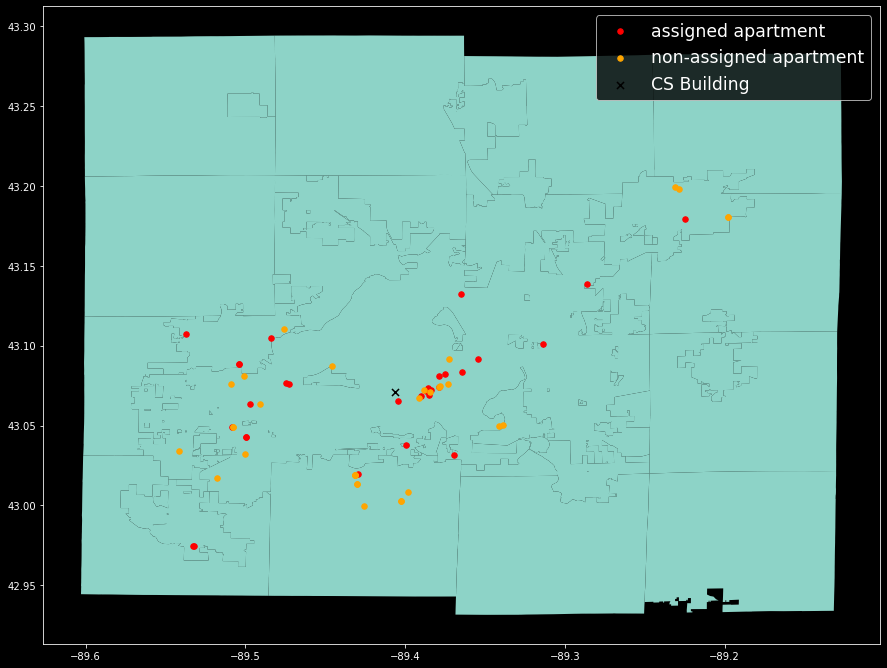

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
map[(maplat < 43.25) & (maplat >42.95) & (maplon > -89.6) & (maplon < -89.1)].plot(ax=ax)
assigned.plot(ax=ax, markersize=30, color='red', label='assigned apartment')
notassigned.plot(ax=ax, markersize=30, color='orange', label='non-assigned apartment')
cs.plot(ax=ax, markersize=50, color='black', marker='x', label='CS Building')
plt.legend(fontsize='xx-large')

Note the area of apartments right on the lake near where the capitol is downtown. Likely, these are very expensive apartments that are outside a student budget, which is why they weren't assigned.

# Tradeoff model

In [26]:
%%gams 
alias(r2,r);
alias(cr2,cr);
scalars 
        lambda "priority between minimizing average dissatisfaction and max dissatisfaction" /0.4/,
        infty "stand-in for infinity in equations" /1e5/;

free variables 
        avgdis "total dissatisfication",
        maxdis "dissatisfaction of most dissatisfied resident",
        cdis "combined dissatisfaction from average dissatisfaction and the most dissatisfied resident";
    
positive variables disAON(r) "dissatisfaction all or nothing - equals dis(r) if r is most dissatisfied resident and 0 otherwise";

binary variables
        isMax(r) "is the resident who is most dissatisfied",
        isntMax(r) "isnt the resident who is most dissatisfied",
        worse(r,r2) "only able to be 1 if r is at least as dissatisfied as r2",
        better(r, r2) "must be 1 if r is less dissatisfied (=more satisfied) than r2";

equations
        calcavgdis "average dissatisfaction",
        calcmaxdis "dissatisfaction of most dissatisfied resident",
        findbetter(r,r2) "determine if r is happier than r2",
        findworse(r, r2) "if r is less happy from r2",
        calcIsntmax(r) "determine if r can potentially be the most dissatisfied resident",
        calcIsmax(r) "determine if r will be selected as most dissatisfied",
        mostdissed "choose only one resident as the most dissatisfied",
        disaon_lolim1(r) "disAON is 0 if r isnt most dissatisfied",
        disaon_lolim2(r) "disAON isnt greater than dis(r)",
        disaon_hilim(r) "disAON is dis(r) if r is most dissatisfied",
#####################################
# add new obj
        traobj "objective for tradeoff model";
#####################################

findbetter(cr, cr2)..
better(cr, cr2) =g= (rdis(cr2) - rdis(cr)) / infty;

findworse(cr, cr2)..
worse(cr, cr2) + better(cr, cr2) =e= 1;

calcIsntmax(cr)..
isntMax(cr) =g= 1/num_res * (-sum(cr2, worse(cr,cr2) ) + card(cr));

calcIsmax(cr)..
isMax(cr) + isntMax(cr) =e= 1;

mostdissed..
sum(cr, isMax(cr)) =e= 1;

disaon_lolim1(cr)..
disAON(cr) =l= infty * isMax(cr);

disaon_lolim2(cr)..
0 =l= rdis(cr) - disAON(cr);

disaon_hilim(cr)..
rdis(cr) - disAON(cr) =l= infty * (1-isMax(cr));

calcavgdis..
avgdis =e= (1/card(cr)) * sum(cr, rdis(cr));

calcmaxdis..
maxdis =e= sum(cr, disAON(cr));

traobj..
cdis =e= lambda*avgdis + (1-lambda)*maxdis;

# newobj here
model tra_model /traobj+calcdis+bound_1+bound_2+bound_3+findbetter+findworse+calcIsntmax+calcIsmax+mostdissed+disaon_lolim1+disaon_lolim2+disaon_hilim+calcavgdis+calcmaxdis/;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),1.0788,2078,3813,MIP,CPLEX,0.84


## Model Analysis

### How does the tradeoff model perform with different lambda?

The lambda is designed as the tradeoff parameter between the average dissatisfaction, "avgdis", and the maximum dissatisfaction "maxdis". By decreasing lambda from 1 to 0, the model pays more and more effort on minimizing the max dissatisfaction. However, while the max dissatisfaction are minimized, the average dissatisfaction are increasing. In this part, we would like to discuss how these two values evolve with the decrease of lambda.

We would set lambda = {1, 0.97, 0.95, 0.93, 0.90, 0.85, 0.80, 0.30, 0.15, 0.10, 0.07, 0.05, 0.03, 0}, and compare the variables "avgdis" and "maxdis".

In [27]:
%%gams
lambda=1;
solve tra_model using mip min cdis;
parameter avgdis_1, maxdis_1;
avgdis_1 = avgdis.l;
maxdis_1 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),0.6967,2078,3813,MIP,CPLEX,0.127


In [28]:
%gams_pull -d avgdis_1
%gams_pull -d maxdis_1
print(avgdis_1)
print(maxdis_1)

      value
0  0.696661
      value
0  1.356512


In [29]:
%%gams
lambda=.97;
solve tra_model using mip min cdis;
parameter avgdis_97, maxdis_97;
avgdis_97 = avgdis.l;
maxdis_97 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7164,2078,3813,MIP,CPLEX,0.748


In [30]:
%gams_pull -d avgdis_97
%gams_pull -d maxdis_97
print(avgdis_97)
print(maxdis_97)

      value
0  0.696594
      value
0  1.356512


In [31]:
%%gams
lambda=.95;
solve tra_model using mip min cdis;
parameter avgdis_95, maxdis_95;
avgdis_95 = avgdis.l;
maxdis_95 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7296,2078,3813,MIP,CPLEX,0.722


In [32]:
%gams_pull -d avgdis_95
%gams_pull -d maxdis_95
print(avgdis_95)
print(maxdis_95)

      value
0  0.696594
      value
0  1.356512


In [33]:
%%gams
lambda=.93;
solve tra_model using mip min cdis;
parameter avgdis_93, maxdis_93;
avgdis_93 = avgdis.l;
maxdis_93 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7428,2078,3813,MIP,CPLEX,0.628


In [34]:
%gams_pull -d avgdis_93
%gams_pull -d maxdis_93
print(avgdis_93)
print(maxdis_93)

      value
0  0.696594
      value
0  1.356512


In [35]:
%%gams
lambda=.90;
solve tra_model using mip min cdis;
parameter avgdis_90, maxdis_90;
avgdis_90 = avgdis.l;
maxdis_90 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7626,2078,3813,MIP,CPLEX,0.531


In [36]:
%gams_pull -d avgdis_90
%gams_pull -d maxdis_90
print(avgdis_90)
print(maxdis_90)

      value
0  0.696594
      value
0  1.356512


In [37]:
%%gams
lambda=.85;
solve tra_model using mip min cdis;
parameter avgdis_85, maxdis_85;
avgdis_85 = avgdis.l;
maxdis_85 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7956,2078,3813,MIP,CPLEX,0.653


In [38]:
%gams_pull -d avgdis_85
%gams_pull -d maxdis_85
print(avgdis_85)
print(maxdis_85)

      value
0  0.696594
      value
0  1.356512


In [39]:
%%gams
lambda=.80;
solve tra_model using mip min cdis;
parameter avgdis_80, maxdis_80;
avgdis_80 = avgdis.l;
maxdis_80 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.8286,2078,3813,MIP,CPLEX,1.096


In [40]:
%gams_pull -d avgdis_80
%gams_pull -d maxdis_80
print(avgdis_80)
print(maxdis_80)

      value
0  0.696594
      value
0  1.356512


In [41]:
%%gams
lambda=.3;
solve tra_model using mip min cdis;
parameter avgdis_3, maxdis_3;
avgdis_3 = avgdis.l;
maxdis_3 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.137,2078,3813,MIP,CPLEX,0.488


In [42]:
%gams_pull -d avgdis_3
%gams_pull -d maxdis_3
print(avgdis_3)
print(maxdis_3)

      value
0  0.729289
      value
0  1.311782


In [43]:
%%gams
lambda=.15;
solve tra_model using mip min cdis;
parameter avgdis_15, maxdis_15;
avgdis_15 = avgdis.l;
maxdis_15 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),1.2244,2078,3813,MIP,CPLEX,0.951


In [44]:
%gams_pull -d avgdis_15
%gams_pull -d maxdis_15
print(avgdis_15)
print(maxdis_15)

      value
0  0.729294
      value
0  1.311782


In [45]:
%%gams
lambda=.1;
solve tra_model using mip min cdis;
parameter avgdis_10, maxdis_10;
avgdis_10 = avgdis.l;
maxdis_10 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),1.2535,2078,3813,MIP,CPLEX,0.711


In [46]:
%gams_pull -d avgdis_10
%gams_pull -d maxdis_10
print(avgdis_10)
print(maxdis_10)

      value
0  0.729289
      value
0  1.311782


In [47]:
%%gams
lambda=.07;
solve tra_model using mip min cdis;
parameter avgdis_07, maxdis_07;
avgdis_07 = avgdis.l;
maxdis_07 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),1.271,2078,3813,MIP,CPLEX,0.497


In [48]:
%gams_pull -d avgdis_07
%gams_pull -d maxdis_07
print(avgdis_07)
print(maxdis_07)

      value
0  0.729294
      value
0  1.311782


In [49]:
%%gams
lambda=.05;
solve tra_model using mip min cdis;
parameter avgdis_05, maxdis_05;
avgdis_05 = avgdis.l;
maxdis_05 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.2827,2078,3813,MIP,CPLEX,0.565


In [50]:
%gams_pull -d avgdis_05
%gams_pull -d maxdis_05
print(avgdis_05)
print(maxdis_05)

      value
0  0.729294
      value
0  1.311782


In [51]:
%%gams
lambda=.03;
solve tra_model using mip min cdis;
parameter avgdis_03, maxdis_03;
avgdis_03 = avgdis.l;
maxdis_03 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.2943,2078,3813,MIP,CPLEX,0.521


In [52]:
%gams_pull -d avgdis_03
%gams_pull -d maxdis_03
print(avgdis_03)
print(maxdis_03)

      value
0  0.729294
      value
0  1.311782


In [53]:
%%gams
lambda=0;
solve tra_model using mip min cdis;
parameter avgdis_0, maxdis_0;
avgdis_0 = avgdis.l;
maxdis_0 = maxdis.l;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.3118,2078,3813,MIP,CPLEX,0.393


In [54]:
%gams_pull -d avgdis_0
%gams_pull -d maxdis_0
print(avgdis_0)
print(maxdis_0)

      value
0  0.915259
      value
0  1.311782


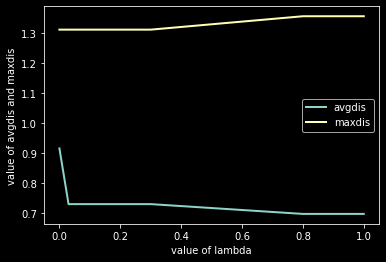

In [55]:
import numpy as np
# make data
x = np.array([1, 0.97, 0.95, 0.93, 0.90, 0.85, 0.80, 0.30, 0.15, 0.10, 0.07, 0.05, 0.03, 0])
y_1 = np.array([avgdis_1,avgdis_97,avgdis_95,avgdis_93,avgdis_90,avgdis_85,avgdis_80,avgdis_3,avgdis_15,avgdis_10,avgdis_07,avgdis_05,avgdis_03,avgdis_0])
y_1 = y_1.ravel()
y_2 = np.array([maxdis_1,maxdis_97,maxdis_95,maxdis_93,maxdis_90,maxdis_85,maxdis_80,maxdis_3,maxdis_15,maxdis_10,maxdis_07,maxdis_05,maxdis_03,maxdis_0])
y_2 = y_2.ravel()

#fig, ax = plt.subplots()

#ax.plot(x, y_1, linewidth=2.0)
#ax.plot(x, y_2, linewidth=2.0)

#ax.set(xlim=(0, 1), ylim=(0.45, 0.65))

plt.plot(x, y_1, linewidth=2.0, label = 'avgdis')
plt.plot(x, y_2, linewidth=2.0, label = 'maxdis')
plt.legend()
plt.xlabel('value of lambda')
plt.ylabel('value of avgdis and maxdis')
plt.show()

#### Conclusion

The graph shows the following property of this model:
1. When lambda = 1, it only cares aboout minimizing avgdis, therefore, we get the minimal avgdis: 0.510446 but the largest maxdis: 1.123596.
2. When lambda decreases a little to 0.97, 0.95, until 0.93 the avgdis increases slowly to 0.519444 and the maxdis decreases greatly to 0.949853. This observation shows the superiority of the model: it is able to find a maxdis which is close to the minimal value and only increase the avgdis a little. In the other word, we are able to assign a better apartment to the resident who received the most dissatisfying one, and in the mean time, not disturbing other residents.
3. Both avgdis and maxdis reaches a stable stage where avgdis increases slowly and maxdis decreases slowly while lambda converging to 0.
4. When lambda reached 0, maxdis arrived at its minimal 0.93754, but since the avgdis is no longer maintain, it reaches its highest level: 0.634159.

### How does the tradeoff model perform in extreme scenarios? Is it robust?

Here, the model is tested by several extreme scenarios to see whether it can still output resonable solutions. 

The following scenarios are considered:

#### 1. Suppose some resident 100% wants a one-bed apartment and doesn't care about anything else. Let's simulate this scenario, then check if this resident's assigned apartment is indeed a 1-bedroom.

In [56]:
%%gams
*reset lambda
lambda=0.8;
* one abnormal resident who 100% only wants a one-bed apartment
parameter rank1old(labels);
rank1old(labels) = rank('1', labels);
rank('1', labels) = 0;
rank('1', 'nbed') = 1;
solve tra_model using mip minimizing cdis;
rank('1', labels) = rank1old(labels);
parameter bl(r,a);
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.8058,2078,3813,MIP,CPLEX,1.958


In [57]:
%gams_pull -d bl
bl.iloc[0]['a']
# which apartment number did the resident get?

'a22'

In [58]:
apartments.loc[28] #because GAMS uses indexing starting from 1 and python starting from 0

nbath                                                           2
propertyType                                                CONDO
lotAreaValue                                                 -1.0
address                 351 W Wilson St UNIT 4, Madison, WI 53703
imgSrc          https://photos.zillowstatic.com/fp/14a473c283b...
budget                                                     3300.0
longitude                                              -89.385315
latitude                                                43.069065
nbed                                                            1
livingArea                                                    894
hasImage                                                     True
car                                                             5
walk                                                           24
bike                                                            8
geometry                     POINT (-89.38531500000001 43.069065)
a         

#### Apartment 28 is indeed a 1-bedroom!

#### 2. Suppose everyone has the exact same apartment preferences. Make everyone have the same preferences as the first resident originally did, which are as follows:

In [59]:
res[res['r']=='1'] # what they want

,r,labels,value
0,1,nbed,3.0
1,1,nbath,2.0
2,1,budget,1463.436074
3,1,com_m,3.0
4,1,com_t,2.0


In [60]:
rank[rank['r']=='1'] #how badly they want each of these things

,r,labels,value
0,1,nbed,0.092014
1,1,nbath,0.451784
2,1,budget,0.294866
3,1,com_t,0.161336


In [61]:
%%gams
parameter rankold(r, labels);
parameter resold(r, labels);
rankold(r, labels) = rank(r, labels);
resold(r, labels) = res(r, labels);
rank(r, labels) = rank('1', labels);
res(r, labels) = res('1', labels);
solve tra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.8717,2078,3813,MIP,CPLEX,0.186


#### This is a fairly large dissatisfaction amount (0.7191), which makes sense because it's hard to please everybody when they all want the same thing even if that thing is relatively reasonable. 

#### 3. Suppose everybody refers the same thing that's relatively strange.

In [62]:
%%gams
rank(r, labels) = 0;
rank(r, 'budget') = 0.5;
rank(r, 'nbed') = 0.5;
# * be sure to normalize budget again
res(r, 'budget') = 100;
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
res(r, 'nbed') = 5;

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
solve tra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),2.9957,2078,3813,MIP,CPLEX,9.395


#### The model takes a long time to solve and gets the giant objective value of 2.996. It is resonable that nobody is all that happy in this extreme scenario.

#### 4. Use the large dataset of 100 residents to see what happens when only some people are able to recieve an apartment.

In [63]:
%%gams
cr(r) = yes;
res(r, labels) = big(r, labels);
scalar old_num;
old_num = num_res;
num_res=100;
pairs = min(card(cr), card(a));
alias(cr2, cr);
################################
# reset rank
rank(r,labels)=rankold(r,labels);
#################################
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));
solve tra_model using mip minimizing cdis;
bl(r,a) = b.l(r,a);
parameter rdis_100(r);
rdis_100(r) = rdis.l(r);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.7644,20768,26703,MIP,CPLEX,18.777


In [64]:
%gams_pull -d bl
%gams_pull -d rdis_100
%gams_pull -d num_res
bl.shape

print(bl)
print(rdis_100)
print(num_res)

     r    a value
0    1   a6   1.0
1    2  a24   1.0
2    4  a39   1.0
3    5  a35   1.0
4    6  a37   1.0
5    7  a30   1.0
6    8  a15   1.0
7    9  a52   1.0
8   10   a9   1.0
9   11  a45   1.0
10  12   a8   1.0
11  13  a28   1.0
12  14  a21   1.0
13  15  a34   1.0
14  16  a29   1.0
15  17  a36   1.0
16  18  a54   1.0
17  19  a41   1.0
18  22  a12   1.0
19  23  a31   1.0
20  24  a32   1.0
21  25  a44   1.0
22  27  a14   1.0
23  28  a38   1.0
24  29  a56   1.0
25  30  a27   1.0
26  32  a63   1.0
27  33  a46   1.0
28  35  a61   1.0
29  37   a7   1.0
30  38  a10   1.0
31  41  a18   1.0
32  42  a50   1.0
33  45  a43   1.0
34  46  a57   1.0
35  47  a48   1.0
36  48  a26   1.0
37  49   a2   1.0
38  50  a11   1.0
39  51  a40   1.0
40  53   a1   1.0
41  60  a33   1.0
42  61  a42   1.0
43  62  a60   1.0
44  63   a5   1.0
45  64  a59   1.0
46  65  a25   1.0
47  66  a23   1.0
48  67  a49   1.0
49  68  a20   1.0
50  69  a17   1.0
51  71  a16   1.0
52  73  a62   1.0
53  75   a3   1.0
54  76  a1

#### Variable b.l(r,a) shows the model deal with this situation by ignoring some of the residents and only 63 residents were able to get apartments. Since the dissatisfaction is about people that get assigned an apartment, the average dissatisfaction is close to the one of the small data set.

Reset data.

In [65]:
%%gams
num_res=old_num;
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
res(r, labels) = resold(r, labels);

In [67]:
%%gams
################################
# reset rank
rank(r,labels)=rankold(r,labels);
#################################
# reset abs
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));

# Stochastic tradeoff model
stochastic model details:

* match every resident registered in the past week to current apartments every Mon;
* each resident is assigned a register time, from 1-7, where 1 -> 1 day ago, 2 -> 2 days ago, etc.;
* for each register time, there is a pobability that the resident would quit before the matching process;
* this probability is set manually;
* if a resident quits, his/hers dissatisfication is set to 0; 
* the rest of the model remain unchanged;

In [68]:
%%gams
set t week days /1*7/;

parameter regtim(r) "the registration time of each resident r";

regtim(r) = ceil(uniform(0,7));

parameter quitprob(t) "the probability of quitting on the t-th day after registration"
/1 0.05
 2 0.05
 3 0.7
 4 0.9
 5 0.12
 6 0.15
 7 0.18/;

equation calcErdis(r,t) "calculate the expected dissatisfication of resident r";

calcErdis(r,t) $ (ord(t)=regtim(r))..
rdis(r) =e= (1-quitprob(t))*sum(a, b(r,a) * (rank(r, 'nbed')*abs_diff(r,a,'nbed') + rank(r, 'nbath')*abs_diff(r,a,'nbath') + rank(r, 'budget')*abs_diff(r,a,'budget')))
        + (1-quitprob(t))*sum(a, b(r,a) * rank(r,'com_t')*abs_diff_cmt(r,a));
* second line is Expected dissatisfaction with commute, first line is expected dissatisfaction with everything else

model stotra_model /traobj, calcavgdis, calcmaxdis, calcErdis, findbetter, findworse, calcIsntmax,
                calcIsmax, mostdissed, disaon_lolim1, disaon_lolim2, disaon_hilim, bound_1, 
                bound_2, bound_3/;

solve stotra_model using mip min cdis;
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.024


In [69]:
%%gams
lambda=1;
solve stotra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.03


In [70]:
%%gams
lambda=.7;
solve stotra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.025


In [71]:
%%gams
lambda=.3;
solve stotra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.029


In [72]:
%%gams
lambda=0;
solve stotra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.021


abnormal resident

In [73]:
%%gams
*reset lambda
lambda=0.5;
* one abnormal resident who 100% only wants a one-bed apartment
parameter rank1old(labels);
rank1old(labels) = rank('1', labels);
rank('1', labels) = 0;
rank('1', 'nbed') = 1;
solve stotra_model using mip minimizing cdis;
rank('1', labels) = rank1old(labels);
parameter bl(r,a);
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.022


everyone has the same request and ranking

In [74]:
res[res['r']=='1'] # what they want
rank[rank['r']=='1'] #how badly they want each of these things

,r,labels,value
0,1,nbed,0.092014
1,1,nbath,0.451784
2,1,budget,0.294866
3,1,com_t,0.161336


In [75]:
%%gams
parameter rankold(r, labels);
parameter resold(r, labels);
rankold(r, labels) = rank(r, labels);
resold(r, labels) = res(r, labels);
rank(r, labels) = rank('1', labels);
res(r, labels) = res('1', labels);
solve stotra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.03


everyone has the same wierd preference

In [76]:
%%gams
rank(r, labels) = 0;
rank(r, 'budget') = 0.5;
rank(r, 'nbed') = 0.5;
# * be sure to normalize budget again
res(r, 'budget') = 100;
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
res(r, 'nbed') = 5;

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
solve stotra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.029


100 residents data set

In [77]:
%%gams
cr(r) = yes;
res(r, labels) = big(r, labels);
scalar old_num;
old_num = num_res;
num_res=100;
pairs = min(card(cr), card(a));
alias(cr2, cr);
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));
solve tra_model using mip minimizing cdis;
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),10.2849,20768,26703,MIP,CPLEX,6.621


reset data

In [78]:
%%gams
num_res=old_num;
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
res(r, labels) = resold(r, labels);